# Model VGGNet and FCN Define and setup as Extractor and Decoder
## Breast-Ultrasound-Segmentation

## About Dataset
Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

### Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

If you use this dataset, please cite:
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}/data"

In [2]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [3]:
import hydra
from hydra import compose, initialize

In [4]:
# # auto reload dotenv
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths setup

In [5]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="training_setup", version_base=None):
    cfg: DictConfig = compose(config_name="train.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}'}


In [6]:
os.chdir(root)

## Loading Dataset

In [7]:
data_module = hydra.utils.instantiate(cfg.datamodule)
train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()

In [8]:
for images, targets in train_dl:
    break
print(images.shape, targets["masks"].shape, targets["labels"].shape)

print(f"images:{images.dtype}, {images[0].min()}, {images[0].max()}")
print(f'masks {targets["masks"].dtype}, {targets["masks"][0].min()}, {targets["masks"][0].max()}')
print(
    f'labels {targets["labels"].dtype}, {targets["labels"][0].min()}, {targets["labels"][0].max()}'
)

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256]) torch.Size([32, 3])
images:torch.float32, 0.0, 0.9411765336990356
masks torch.uint8, 0, 255
labels torch.float32, 0.0, 1.0


In [9]:
for _images, _targets in val_dl:
    break
print(_images.shape, _targets["masks"].shape, _targets["labels"].shape)

print(f"images:{_images[0].dtype}, {_images[0].min()}, {_images[0].max()}")
print(f'masks {_targets["masks"].dtype}, {_targets["masks"].min()}, {_targets["masks"].max()}')
print(f'labels {_targets["labels"].dtype}, {_targets["labels"].min()}, {_targets["labels"].max()}')

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256]) torch.Size([32, 3])
images:torch.float32, 0.0, 0.9764706492424011
masks torch.uint8, 0, 255
labels torch.float32, 0.0, 1.0


## VGG-16 as feature extractor and FCN-8 as network upsampling and generating the predictions

### Define VGG-16
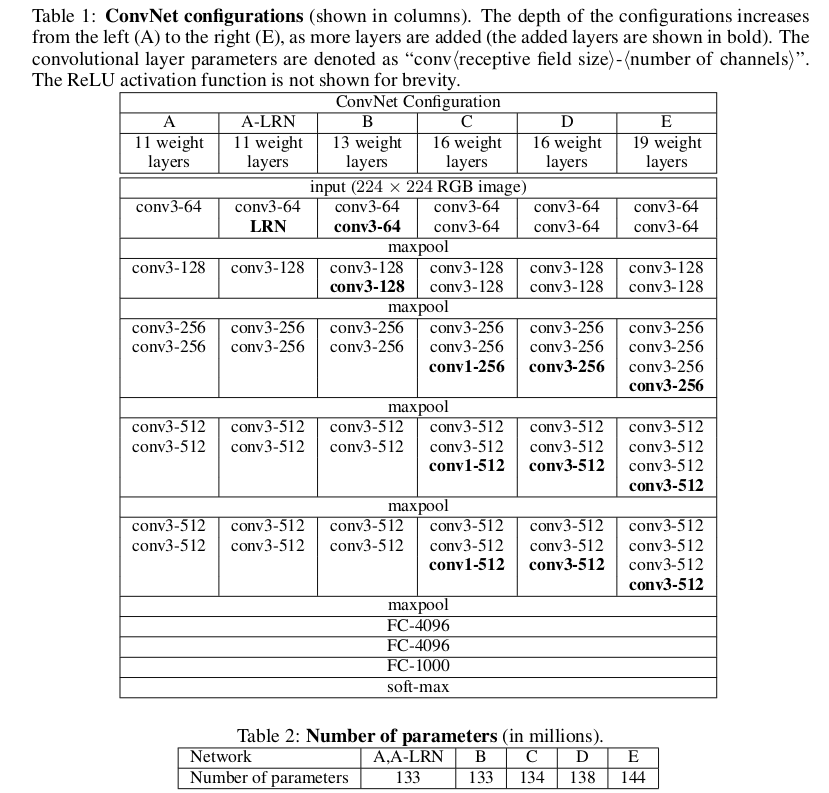

In [10]:
import torch.nn as nn


class VGGNet(nn.Module):
    def __init__(
        self, input_shape: tuple = (3, 256, 256), num_classes: int = 3, vgg_type: str = "vgg19"
    ):
        super(VGGNet, self).__init__()
        self.vgg_types = {
            "vgg11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
            "vgg13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
            "vgg16": [
                64,
                64,
                "M",
                128,
                128,
                "M",
                256,
                256,
                256,
                "M",
                512,
                512,
                512,
                "M",
                512,
                512,
                512,
                "M",
            ],
            "vgg19": [
                64,
                64,
                "M",
                128,
                128,
                "M",
                256,
                256,
                256,
                256,
                "M",
                512,
                512,
                512,
                512,
                "M",
                512,
                512,
                512,
                512,
                "M",
            ],
        }
        self.in_channels = input_shape[0]
        self._conv_layers = self._create_conv_layers(self.vgg_types[vgg_type])
        # Determine the output shape of the convolutional layers automatically
        with torch.no_grad():
            dummy_input = torch.randn(1, self.in_channels, input_shape[1], input_shape[2])
            output = self._conv_layers(dummy_input)

            # output.size - [32,512,4,4]
            # output.view(output.size(0), -1).shape - [32, 512*4*4] (-1 mean use all elements/flatten)
            self.flattened_size = output.view(output.size(0), -1).shape[1]

        self._classifier = nn.Sequential(
            nn.Linear(in_features=self.flattened_size, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

    def _create_conv_layers(self, architecture) -> nn.Sequential:
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if x == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True),
                ]
                in_channels = x
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)

    def forward(self, x) -> torch.Tensor:
        x = self._conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self._classifier(x)
        return x

In [11]:
input_tensor = torch.randn(1, 1, 224, 224)  # Example input (batch_size, channels, height, width)
vggnet11_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg11")
output = vggnet11_model(input_tensor)

In [12]:
from torchinfo import summary

batch_size = 16
summary(vggnet11_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-4                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-5                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-6                  [16, 128, 112, 112]       256
│    └─ReLU: 2-7                         [16, 128, 112, 112]       --
│    └─MaxPool2d: 2-8                    [16, 128, 56, 56]         --
│    └─Conv2d: 2-9                       [16, 256, 56, 56]         295,168
│    └─BatchNorm2d: 2-10                 [16, 256, 56, 56]         512
│    └─ReLU: 2-11                        [16, 256, 56, 56]         --
│ 

In [13]:
vggnet13_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg13")
output = vggnet13_model(input_tensor)
summary(vggnet13_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [14]:
vggnet16_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg16")
output = vggnet16_model(input_tensor)
summary(vggnet16_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [15]:
vggnet19_model = VGGNet(input_shape=input_tensor.shape[1:], num_classes=3, vgg_type="vgg19")
output = vggnet19_model(input_tensor)
summary(vggnet19_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [16]:
from src.models.components.nets.vanilla_vggnet_feature_extractor import (
    VanillaVGGNetFeatureExtractor,
)

vanilla_vggnet_model = VanillaVGGNetFeatureExtractor(
    input_shape=input_tensor.shape[1:], vgg_type="vgg19"
)
output = vanilla_vggnet_model(input_tensor)
summary(vanilla_vggnet_model, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaVGGNetFeatureExtractor            [16, 64, 112, 112]        --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        640
│    └─BatchNorm2d: 2-2                  [16, 64, 224, 224]        128
│    └─ReLU: 2-3                         [16, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [16, 64, 224, 224]        128
│    └─ReLU: 2-6                         [16, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [16, 128, 112, 112]       256
│    └─ReLU: 2-10                        [16, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,58

In [17]:
layers = vanilla_vggnet_model._conv_layers
for layer in layers:
    # x = layer(x)
    if isinstance(layer, nn.MaxPool2d):
        print(layer)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [18]:
len(layers), len(output)

(54, 6)

## Setup Fully Convolution Neural Network